In [1]:
'''
                           _ooOoo_
                          o8888888o
                          88" . "88
                          (| -_- |)
                          O\  =  /O
                       ____/`---'\____
                     .'  \\|     |//  `.
                    /  \\|||  :  |||//  \
                   /  _||||| -:- |||||-  \
                   |   | \\\  -  /// |   |
                   | \_|  ''\---/''  |   |
                   \  .-\__  `-`  ___/-. /
                 ___`. .'  /--.--\  `. . __
              ."" '<  `.___\_<|>_/___.'  >'"".
             | | :  `- \`.;`\ _ /`;.`/ - ` : | |
             \  \ `-.   \_ __\ /__ _/   .-` /  /
        ======`-.____`-.___\_____/___.-`____.-'======
                           `=---='
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          一心向善	好运相伴	佛祖保佑	永无BUG
'''
from __future__ import print_function # 将python3中的print特性导入当前版本
from collections import OrderedDict # 有序字典
import matplotlib.pyplot as plt # 绘制曲线
import numpy as np # 懂的都懂
import pickle # 对象打包
import gzip  # 解压模块

"""
----------------------------
加载和初始化mnist数据集
----------------------------
"""
# 初始化文件列表
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# 定义原始数据路径和初始化后的数据集路径
dataset_dir = os.path.dirname(os.path.abspath('__file__')) + "/dataset"
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000 # 训练次数
test_num = 10000 # 测试次数
img_dim = (1, 28, 28) # 图像大小是28*28像素
img_size = 784 # 28*28=784

# 定义加载图像数据集的函数
def load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    return data

# 定义加载标签数据集的函数
def load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    return labels

# 定义将数据集格式化的函数
def convert_numpy():
    dataset = {}
    dataset['train_img'] =  load_img(key_file['train_img'])
    dataset['train_label'] = load_label(key_file['train_label'])
    dataset['test_img'] = load_img(key_file['test_img'])
    dataset['test_label'] = load_label(key_file['test_label'])
    return dataset

# 定义初始化数据集，数据集保存成pickle
def init_mnist():
    dataset = convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

# 定义选择标签返回形式的函数
def change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

# 定义加载mnist数据集的函数
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """
    --------------------------------------------------------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label :
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组

    Returns : (训练图像, 训练标签), (测试图像, 测试标签)
    --------------------------------------------------------
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [2]:
"""
------------------------------------------
定义 ：sigmoid、relu、Softmax、交叉熵损失函数
------------------------------------------
"""
# 根据sigmoid函数的定义
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# sigmoid函数梯度
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

# 根据relu函数的定义
def relu(x):
    return np.maximum(0, x)

# relu函数梯度
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

# Softmax输出类别函数
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # 溢出的解决
    return np.exp(x) / np.sum(np.exp(x))

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

def identity_function(x):
    return x

def step_function(x):
    return np.array(x > 0, dtype=np.int)

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

# 交叉熵损失函数
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size



In [3]:
"""
------------------------------------------
定义 ：网络层
------------------------------------------
"""
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx


class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [4]:
"""
------------------------------------------
定义算法 : SGD、梯度计算
------------------------------------------
"""
class SGD:
    # 随机梯度下降（Stochastic Gradient Descent）
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


def _numerical_gradient_1d(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    
    # 多维迭代
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad



In [5]:
"""
------------------------------------------
定义 : 进行神经网络的训练的类
------------------------------------------
"""
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
        self.train_loss = []
        self.test_loss = []

        # 使用SGD算法优化
        optimizer_class_dict = {'sgd':SGD}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        # if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            self.train_loss.append(1-train_acc)
            self.test_loss.append(1-test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", Train accuracy:" + str(train_acc) + ", Test accuracy:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("Test accuracy:" + str(test_acc))

In [6]:
"""
------------------------------------------
定义 : 简单的神经网络
    conv - relu  - affine - relu - dropout - affine - dropout - softmax
    
    Parameters
    ----------
    input_size : 输入大小（784像素）
    hidden_size_list : 隐藏层的神经元数量的列表
    output_size : 输出大小（10种类型的数字）
    activation : 'Relu' or 'Sigmoid'
    weight_init_std : 指定权重的标准差
------------------------------------------
"""
class SimpleNet:
    def __init__(self, input_size = 784, hidden_size=100, output_size=10, weight_init_std=0.01, 
                activation = Relu(), DropoutFlag = 1):

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Relu1'] = activation
        # self.layers['Relu1'] = Dropout(DropoutFlag)
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        # self.layers['Affine1'] = Dropout(DropoutFlag)
        self.layers['Relu2'] = activation
        self.layers['Relu2'] = Dropout(DropoutFlag)
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """ 
        求损失函数
        参数x是数据、t是标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """
        求梯度（数值微分）

        Parameters
        ----------
        x : 数据
        t : 标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2'] 各层的权重
            grads['b1']、grads['b2'] 各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """
        求梯度（误差反向传播法）

        Parameters
        ----------
        x : 数据
        t : 标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2'] 各层的权重
            grads['b1']、grads['b2'] 各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

=== epoch:1, Train accuracy:0.109, Test accuracy:0.115 ===
=== epoch:2, Train accuracy:0.221, Test accuracy:0.163 ===
=== epoch:3, Train accuracy:0.403, Test accuracy:0.389 ===
=== epoch:4, Train accuracy:0.384, Test accuracy:0.352 ===
=== epoch:5, Train accuracy:0.478, Test accuracy:0.436 ===
=== epoch:6, Train accuracy:0.55, Test accuracy:0.517 ===
=== epoch:7, Train accuracy:0.63, Test accuracy:0.62 ===
=== epoch:8, Train accuracy:0.63, Test accuracy:0.624 ===
=== epoch:9, Train accuracy:0.66, Test accuracy:0.671 ===
=== epoch:10, Train accuracy:0.708, Test accuracy:0.706 ===
=== epoch:11, Train accuracy:0.764, Test accuracy:0.74 ===
=== epoch:12, Train accuracy:0.786, Test accuracy:0.765 ===
=== epoch:13, Train accuracy:0.801, Test accuracy:0.778 ===
=== epoch:14, Train accuracy:0.804, Test accuracy:0.787 ===
=== epoch:15, Train accuracy:0.816, Test accuracy:0.794 ===
=== epoch:16, Train accuracy:0.826, Test accuracy:0.809 ===
=== epoch:17, Train accuracy:0.825, Test accuracy:0.797

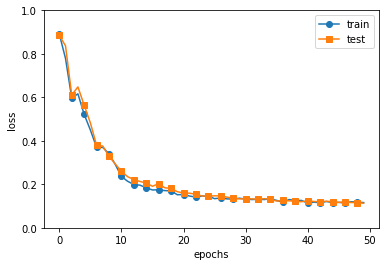

In [7]:
'''
------------------------------
情形1 : 激活函数使用Sigmoid()
隐藏层维度500，学习率0.005，这俩需要设置的比使用Relu要大，才能达到比较高的准确率（90.1）;
小批量样本100；
训练速度相对就慢；
此处Dropout未介入；
------------------------------
'''
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 50轮
max_epochs = 50
# 初始化网络参数
network = SimpleNet(input_size = 784, hidden_size=500, output_size=10, weight_init_std=0.01, 
                    activation = Sigmoid(), DropoutFlag = 0)
# 训练参数，使用SGD优化                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.005},
                  evaluate_sample_num_per_epoch=1000)
# 开始训练 
trainer.train()

# 保存模型
network.save_params("params_Sigmoid.pkl")
print("Train Completed! Saved Network Parameters!")

# 绘制训练loss曲线和测试loss曲线
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_loss, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_loss, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.show()

=== epoch:1, Train accuracy:0.15, Test accuracy:0.161 ===
=== epoch:2, Train accuracy:0.469, Test accuracy:0.477 ===
=== epoch:3, Train accuracy:0.539, Test accuracy:0.537 ===
=== epoch:4, Train accuracy:0.604, Test accuracy:0.594 ===
=== epoch:5, Train accuracy:0.656, Test accuracy:0.622 ===
=== epoch:6, Train accuracy:0.693, Test accuracy:0.669 ===
=== epoch:7, Train accuracy:0.727, Test accuracy:0.72 ===
=== epoch:8, Train accuracy:0.773, Test accuracy:0.753 ===
=== epoch:9, Train accuracy:0.808, Test accuracy:0.779 ===
=== epoch:10, Train accuracy:0.816, Test accuracy:0.795 ===
=== epoch:11, Train accuracy:0.824, Test accuracy:0.811 ===
=== epoch:12, Train accuracy:0.829, Test accuracy:0.822 ===
=== epoch:13, Train accuracy:0.835, Test accuracy:0.831 ===
=== epoch:14, Train accuracy:0.838, Test accuracy:0.839 ===
=== epoch:15, Train accuracy:0.841, Test accuracy:0.851 ===
=== epoch:16, Train accuracy:0.849, Test accuracy:0.856 ===
=== epoch:17, Train accuracy:0.851, Test accuracy:0

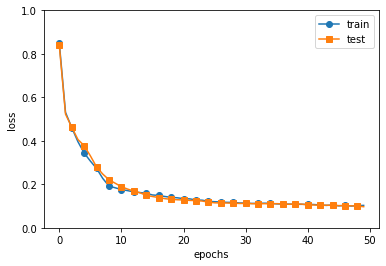

In [8]:
'''
------------------------------
情形2 : 激活函数使用Relu()
隐藏层维度100，学习率0.002，这俩需要设置的比使用Sigmoid小，就能达到比较高的准确率（91.0）;
小批量样本100；
训练速度相对快；
此处Dropout未介入；
------------------------------
'''
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 50轮
max_epochs = 50
# 初始化网络参数
network = SimpleNet(input_size = 784, hidden_size=100, output_size=10, weight_init_std=0.01, 
                    activation = Relu(), DropoutFlag = 0)
# 训练参数，使用SGD优化                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.002},
                  evaluate_sample_num_per_epoch=1000)
# 开始训练 
trainer.train()

# 保存模型
network.save_params("params_Relu.pkl")
print("Train Completed! Saved Network Parameters!")

# 绘制训练loss曲线和测试loss曲线
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_loss, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_loss, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.show()

=== epoch:1, Train accuracy:0.08, Test accuracy:0.11 ===
=== epoch:2, Train accuracy:0.09, Test accuracy:0.11 ===
=== epoch:3, Train accuracy:0.13, Test accuracy:0.11 ===
=== epoch:4, Train accuracy:0.13, Test accuracy:0.13 ===
=== epoch:5, Train accuracy:0.14, Test accuracy:0.15 ===
=== epoch:6, Train accuracy:0.15, Test accuracy:0.15 ===
=== epoch:7, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:8, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:9, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:10, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:11, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:12, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:13, Train accuracy:0.15, Test accuracy:0.14 ===
=== epoch:14, Train accuracy:0.15, Test accuracy:0.15 ===
=== epoch:15, Train accuracy:0.15, Test accuracy:0.15 ===
=== epoch:16, Train accuracy:0.15, Test accuracy:0.15 ===
=== epoch:17, Train accuracy:0.15, Test accuracy:0.15 ===
=== epoch:18, Train acc

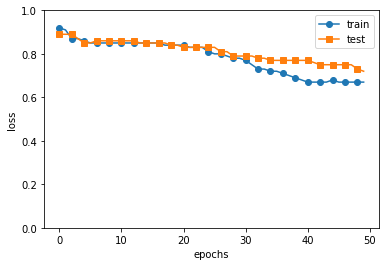

In [9]:
'''
------------------------------
情形3 : 欠拟合效果
隐藏层维度10，学习率0.0001，小批量样本100;
------------------------------
'''
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 50轮
max_epochs = 50
# 初始化网络参数
network = SimpleNet(input_size = 784, hidden_size=10, output_size=10, weight_init_std=0.01, 
                    activation = Relu(), DropoutFlag = 0)
# 训练参数，使用SGD优化                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.0001},
                  evaluate_sample_num_per_epoch=100)
# 开始训练 
trainer.train()

# 保存模型
# network.save_params("params_OF.pkl")
# print("Train Completed! Saved Network Parameters!")

# 绘制训练loss曲线和测试loss曲线
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_loss, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_loss, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.show()

=== epoch:1, Train accuracy:0.0914, Test accuracy:0.1042 ===
=== epoch:2, Train accuracy:0.8138, Test accuracy:0.7734 ===
=== epoch:3, Train accuracy:0.8666, Test accuracy:0.836 ===
=== epoch:4, Train accuracy:0.8882, Test accuracy:0.8546 ===
=== epoch:5, Train accuracy:0.8996, Test accuracy:0.8658 ===
=== epoch:6, Train accuracy:0.9024, Test accuracy:0.8706 ===
=== epoch:7, Train accuracy:0.9068, Test accuracy:0.8738 ===
=== epoch:8, Train accuracy:0.9104, Test accuracy:0.88 ===
=== epoch:9, Train accuracy:0.9126, Test accuracy:0.8828 ===
=== epoch:10, Train accuracy:0.9164, Test accuracy:0.8868 ===
=== epoch:11, Train accuracy:0.9196, Test accuracy:0.8892 ===
=== epoch:12, Train accuracy:0.9192, Test accuracy:0.8932 ===
=== epoch:13, Train accuracy:0.9222, Test accuracy:0.8936 ===
=== epoch:14, Train accuracy:0.9212, Test accuracy:0.8918 ===
=== epoch:15, Train accuracy:0.9218, Test accuracy:0.8938 ===
=== epoch:16, Train accuracy:0.9242, Test accuracy:0.8932 ===
=== epoch:17, Train 

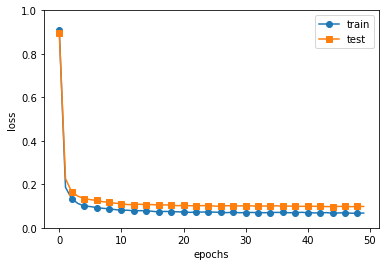

In [10]:
'''
------------------------------
情形4 : 过拟合效果
隐藏层维度700，学习率0.01，每周期选择样本数5000;
此处Dropout未介入；
------------------------------
'''
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 50轮
max_epochs = 50
# 初始化网络参数
network = SimpleNet(input_size = 784, hidden_size=700, output_size=10, weight_init_std=0.01, 
                    activation = Relu(), DropoutFlag = 0)
# 训练参数，使用SGD优化                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.01},
                  evaluate_sample_num_per_epoch=5000)
# 开始训练 
trainer.train()

# 保存模型
# network.save_params("params_TF.pkl")
# print("Train Completed! Saved Network Parameters!")

# 绘制训练loss曲线和测试loss曲线
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_loss, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_loss, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.show()

=== epoch:1, Train accuracy:0.0926, Test accuracy:0.0968 ===
=== epoch:2, Train accuracy:0.6984, Test accuracy:0.6582 ===
=== epoch:3, Train accuracy:0.7744, Test accuracy:0.731 ===
=== epoch:4, Train accuracy:0.8274, Test accuracy:0.787 ===
=== epoch:5, Train accuracy:0.849, Test accuracy:0.813 ===
=== epoch:6, Train accuracy:0.8692, Test accuracy:0.832 ===
=== epoch:7, Train accuracy:0.8798, Test accuracy:0.8452 ===
=== epoch:8, Train accuracy:0.885, Test accuracy:0.8498 ===
=== epoch:9, Train accuracy:0.8916, Test accuracy:0.8548 ===
=== epoch:10, Train accuracy:0.8944, Test accuracy:0.862 ===
=== epoch:11, Train accuracy:0.8978, Test accuracy:0.8662 ===
=== epoch:12, Train accuracy:0.902, Test accuracy:0.8658 ===
=== epoch:13, Train accuracy:0.9024, Test accuracy:0.865 ===
=== epoch:14, Train accuracy:0.9032, Test accuracy:0.8744 ===
=== epoch:15, Train accuracy:0.9074, Test accuracy:0.8746 ===
=== epoch:16, Train accuracy:0.9054, Test accuracy:0.873 ===
=== epoch:17, Train accurac

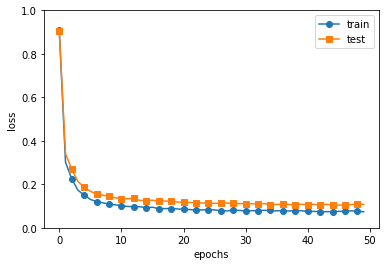

In [11]:
'''
------------------------------
情形5 : 情形4的过拟合效果使用Dropout纠偏
隐藏层维度700，学习率0.01;
Dropout设置0.5；
------------------------------
'''
# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
# 50轮
max_epochs = 50
# 初始化网络参数
network = SimpleNet(input_size = 784, hidden_size=700, output_size=10, weight_init_std=0.01, 
                    activation = Relu(), DropoutFlag = 0.5)
# 训练参数，使用SGD优化                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='SGD', optimizer_param={'lr': 0.01},
                  evaluate_sample_num_per_epoch=5000)
# 开始训练 
trainer.train()

# 保存模型
# network.save_params("params_do.pkl")
# print("Train Completed! Saved Network Parameters!")

# 绘制训练loss曲线和测试loss曲线
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_loss, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_loss, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.show()